**Installing packages, loading libraries, data processing, modeling, and result visualization.

In [1]:
%%capture
!pip install catboost
!pip install pingouin
!pip install ppscore
!pip install pandas === 1.5.3
!pip install shap

#### Load libraries

In [3]:
pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/74/02/5ad29a2a3d193a87d5a05fb7fd3b4e30b8eb6db7a9ddbe193beb7053978f/lightgbm-4.2.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB 660.6 kB/s eta 0:00:02
   -- ------------------------------------- 0.1/1.3 MB 762.6 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.3 MB 1.2 MB/s eta 0:00:02
   -------- ------------------------------- 0.3/1.3 MB 1.4 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.3 MB 1.6 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.3 MB 1.7 MB/s eta 0:00:01
   ------------------ --------------------- 0.6/1.3 MB 1.8 MB/s eta 0:00:01
   ---------------------- ----------------- 0.7/1.3 MB 2.0 MB/s eta 0:00:01
   -------------------------- -------------

In [4]:
# Data Manipulation
#================================================
import pandas as pd
import numpy as np

# Data visualization
#=================================================
import matplotlib.pyplot as plt
import seaborn as sns


# Stats
#==============================================
import pingouin as pg
import statsmodels.api as sm
from scipy import stats
import ppscore as pps

# Data preprocessing
#==================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

# Models
#==================================================
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Metrics
#========================================================
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# shap
#===================================
import shap

# tqdm
#======================================================
from tqdm.auto import tqdm

# Counter
#====================================================
from collections import Counter

# warnings
#=============================================
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Data Loading

data = pd.read_csv("Data/breast-cancer-dataset.csv")

data.head()

,S/N,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Breast,Metastasis,Breast Quadrant,History,Diagnosis Result
0,1,2019,40,1,2,0,Right,0,Upper inner,0,Benign
1,2,2019,39,1,2,0,Left,0,Upper outer,0,Benign
2,3,2019,45,0,4,0,Left,0,Lower outer,0,Benign
3,4,2019,26,1,3,0,Left,0,Lower inner,1,Benign
4,5,2019,21,1,1,0,Right,0,Upper outer,1,Benign


In [6]:
# Dat set size
#==========================================================
rows, columns = data.shape[0], data.shape[1]

print(f'Rows: {rows}')
print(f'Columns: {columns}')

Rows: 213
Columns: 11


In [7]:
# Data set information
#================================================
print("==" * 30)
print(" " * 17, "Data set Information")
print("==" * 30)
print(data.info())

                  Data set Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   S/N               213 non-null    int64 
 1   Year              213 non-null    object
 2   Age               213 non-null    int64 
 3   Menopause         213 non-null    int64 
 4   Tumor Size (cm)   213 non-null    object
 5   Inv-Nodes         213 non-null    object
 6   Breast            213 non-null    object
 7   Metastasis        213 non-null    object
 8   Breast Quadrant   213 non-null    object
 9   History           213 non-null    object
 10  Diagnosis Result  213 non-null    object
dtypes: int64(3), object(8)
memory usage: 18.4+ KB
None


#### Data cleaning
**We are going to remove the white spaces in each variable name.

In [8]:
data.columns = data.columns.str.replace(" ", "")
data.columns

Index(['S/N', 'Year', 'Age', 'Menopause', 'TumorSize(cm)', 'Inv-Nodes',
       'Breast', 'Metastasis', 'BreastQuadrant', 'History', 'DiagnosisResult'],
      dtype='object')

In [9]:
cols_to_verifier = ['Year', 'Age', 'Menopause', 'TumorSize(cm)', 
                    'Inv-Nodes', 'Metastasis', 'History']

for col in cols_to_verifier:
    data[col] = pd.to_numeric(data[col], errors = 'coerce')
    
data.head()

,S/N,Year,Age,Menopause,TumorSize(cm),Inv-Nodes,Breast,Metastasis,BreastQuadrant,History,DiagnosisResult
0,1,2019.0,40,1,2.0,0.0,Right,0.0,Upper inner,0.0,Benign
1,2,2019.0,39,1,2.0,0.0,Left,0.0,Upper outer,0.0,Benign
2,3,2019.0,45,0,4.0,0.0,Left,0.0,Lower outer,0.0,Benign
3,4,2019.0,26,1,3.0,0.0,Left,0.0,Lower inner,1.0,Benign
4,5,2019.0,21,1,1.0,0.0,Right,0.0,Upper outer,1.0,Benign


In [10]:
data['Menopause'].unique()

array([1, 0], dtype=int64)

In [11]:
data['Inv-Nodes'].unique()

array([ 0.,  1., nan,  3.])

In [12]:
data['Inv-Nodes'] = data['Inv-Nodes'].apply(lambda x: x if x == 0. or x == 1. else np.nan)

#### Breast

In [13]:
data['Breast'].unique()

array(['Right', 'Left', '#'], dtype=object)

In [14]:
data['Breast'] = data['Breast'].apply(lambda x: x if x == "Right" or x == "Left" else np.nan)

In [15]:
data['Metastasis'].unique()


array([ 0.,  1., nan])

In [16]:
data['Metastasis'] = data['Metastasis'].apply(lambda x: x if x == 0. or x == 1. else np.nan)

In [17]:
data['BreastQuadrant'].unique()

array(['Upper inner', 'Upper outer', 'Lower outer', 'Lower inner', '#',
       'Upper outer '], dtype=object)

In [18]:
data['BreastQuadrant'] = data['BreastQuadrant'].str.replace(' ', '')

In [19]:
data['BreastQuadrant'] = data['BreastQuadrant'].apply(lambda x: np.nan if x == '#' else x)

In [20]:
data['DiagnosisResult'].unique()

array(['Benign', 'Malignant'], dtype=object)

#### EDA

In [21]:
print(data.duplicated().sum())

0


In [22]:
data = data.drop('S/N', axis = 1)

data.head()

,Year,Age,Menopause,TumorSize(cm),Inv-Nodes,Breast,Metastasis,BreastQuadrant,History,DiagnosisResult
0,2019.0,40,1,2.0,0.0,Right,0.0,Upperinner,0.0,Benign
1,2019.0,39,1,2.0,0.0,Left,0.0,Upperouter,0.0,Benign
2,2019.0,45,0,4.0,0.0,Left,0.0,Lowerouter,0.0,Benign
3,2019.0,26,1,3.0,0.0,Left,0.0,Lowerinner,1.0,Benign
4,2019.0,21,1,1.0,0.0,Right,0.0,Upperouter,1.0,Benign


**Missing values

*now let's check for the presence of missing values

In [24]:
df_null_values = data.isnull().sum().to_frame().rename(columns = {0:'count'})
df_null_values['%'] = (df_null_values['count'] / len(data)) * 100.
df_null_values = df_null_values.sort_values('%', ascending = False)
df_null_values

,count,%
Breast,6,2.816901
Inv-Nodes,2,0.938967
BreastQuadrant,2,0.938967
History,2,0.938967
Year,1,0.469484
TumorSize(cm),1,0.469484
Metastasis,1,0.469484
Age,0,0.000000
Menopause,0,0.000000
DiagnosisResult,0,0.000000


In [25]:
# We look for where the missing values are located.
#====================================================================
null_values = data[data.isnull().any(axis = 1)]
print(f'Cantidad total de filas con valores perdidos: {len(null_values)}')
null_values

Cantidad total de filas con valores perdidos: 9


,Year,Age,Menopause,TumorSize(cm),Inv-Nodes,Breast,Metastasis,BreastQuadrant,History,DiagnosisResult
30,2019.0,56,0,9.0,1.0,Left,1.0,NaN,0.0,Malignant
40,NaN,34,1,NaN,NaN,NaN,NaN,NaN,NaN,Malignant
47,2019.0,25,1,5.0,0.0,NaN,0.0,Upperouter,0.0,Malignant
67,2019.0,40,1,1.0,0.0,Left,0.0,Lowerouter,NaN,Benign
143,2020.0,29,1,2.0,0.0,NaN,0.0,Lowerinner,1.0,Benign
164,2020.0,38,1,2.0,0.0,NaN,0.0,Upperouter,1.0,Benign
166,2020.0,62,0,3.0,1.0,NaN,1.0,Upperinner,1.0,Malignant
178,2020.0,49,1,4.0,0.0,NaN,0.0,Lowerouter,0.0,Benign
208,2020.0,49,1,6.0,NaN,Right,1.0,Lowerinner,1.0,Malignant


In [26]:
data = data.dropna()

In [28]:
#Let's check that all missing values have been removed.
data.isnull().sum()

Year               0
Age                0
Menopause          0
TumorSize(cm)      0
Inv-Nodes          0
Breast             0
Metastasis         0
BreastQuadrant     0
History            0
DiagnosisResult    0
dtype: int64

In [29]:
data_eda = data.copy()
data_eda.head()

,Year,Age,Menopause,TumorSize(cm),Inv-Nodes,Breast,Metastasis,BreastQuadrant,History,DiagnosisResult
0,2019.0,40,1,2.0,0.0,Right,0.0,Upperinner,0.0,Benign
1,2019.0,39,1,2.0,0.0,Left,0.0,Upperouter,0.0,Benign
2,2019.0,45,0,4.0,0.0,Left,0.0,Lowerouter,0.0,Benign
3,2019.0,26,1,3.0,0.0,Left,0.0,Lowerinner,1.0,Benign
4,2019.0,21,1,1.0,0.0,Right,0.0,Upperouter,1.0,Benign


In [30]:
data_eda['Menopause'] = data_eda['Menopause'].apply(lambda x: "Yes" if x == 1 else "No")
data_eda['Metastasis'] = data_eda['Metastasis'].apply(lambda x: "Yes" if x == 1 else "No")
data_eda['Inv-Nodes'] = data_eda['Inv-Nodes'].apply(lambda x: "Yes" if x == 1 else "No")
data_eda['History'] = data_eda['History'].apply(lambda x: "Yes" if x == 1 else "No")

***Now let's start with the univariate analysis

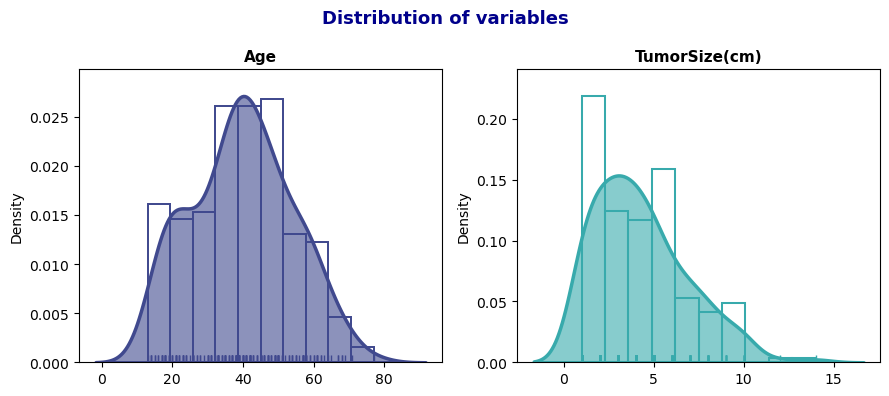

In [31]:
cols_to_plot = ['Age', 'TumorSize(cm)']
colors = sns.color_palette(palette = 'mako', n_colors = len(cols_to_plot))

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
ax = ax.flat
for i,col in enumerate(cols_to_plot):
    sns.kdeplot(data_eda, x = col, alpha = 0.6, fill = True, linewidth = 2.5, color = colors[i], ax = ax[i])
    sns.histplot(data_eda, x = col, stat = 'density', fill = False, color = colors[i], ax = ax[i])
    sns.rugplot(data_eda, x = col, color = colors[i], ax = ax[i])
    ax[i].set_xlabel("")
    ax[i].set_title(col, fontsize = 11, fontweight = "bold", color = "black")
    
fig.suptitle("Distribution of variables", fontsize = 13, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()


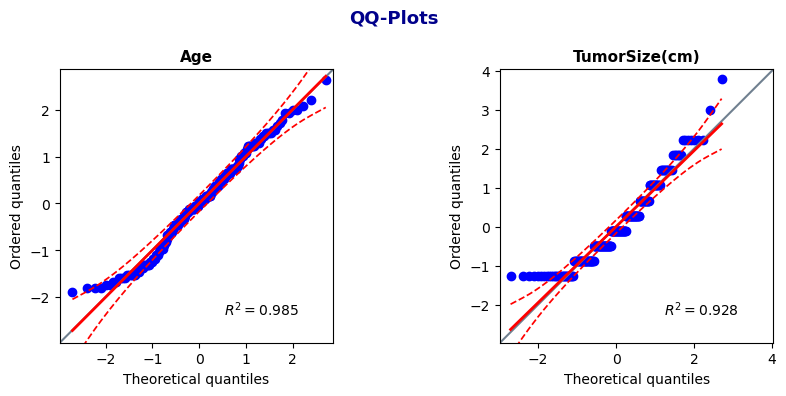

In [32]:
cols_to_plot = ['Age', 'TumorSize(cm)']

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
ax = ax.flat
for i,col in enumerate(cols_to_plot):
    pg.qqplot(data[col], ax = ax[i])
    ax[i].set_title(col, fontsize = 11, fontweight = "bold", color = "black")
    
fig.suptitle("QQ-Plots", fontsize = 13, fontweight = "bold", color = "darkblue")
fig.tight_layout()
fig.show()

**Normality Test

In [33]:
def normality_test(name:str):
    p_value = stats.shapiro(data[name])[1]
    decision = "No Normal Distribution" if p_value < 0.05 else "Normal Distribution"
    return decision

In [34]:
print("--------------------------------------------")
print(" "*5, "Normal Test: Shapiro-Wilk")
print("--------------------------------------------")
for col in cols_to_plot:
    print(f'* {col}: {normality_test(col)}')

--------------------------------------------
      Normal Test: Shapiro-Wilk
--------------------------------------------
* Age: No Normal Distribution
* TumorSize(cm): No Normal Distribution


***In conclusion, none of the variables come from a Population with a Normal Distribution.

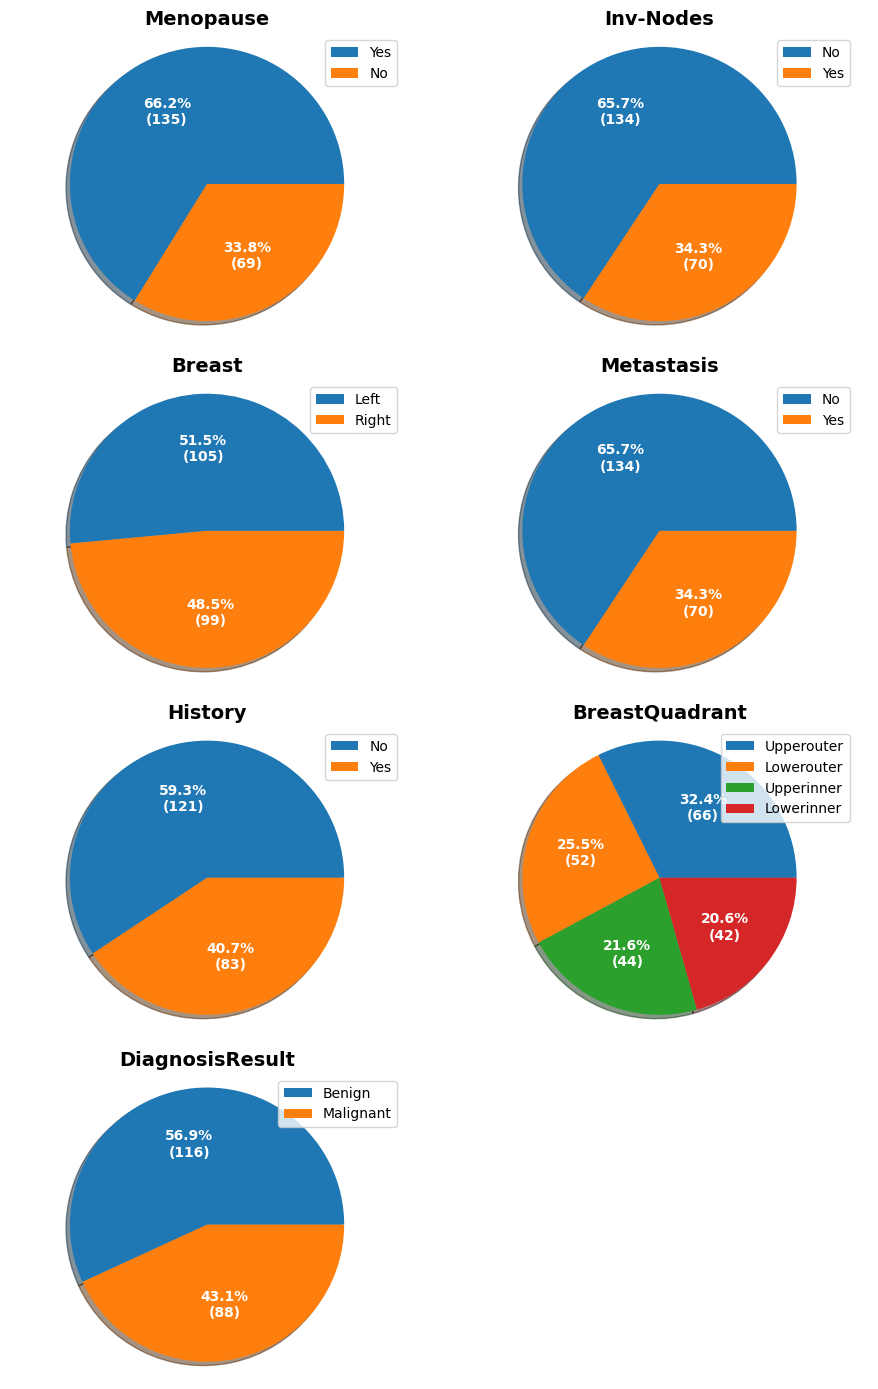

In [35]:
cols_to_plot = ['Menopause', 'Inv-Nodes', 'Breast', 'Metastasis', 
                'History', 'BreastQuadrant', 'DiagnosisResult']

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"

fig,ax = plt.subplots(nrows = 4, ncols = 2, figsize = (9,14))
ax = ax.flat

for i,col in enumerate(cols_to_plot):
    df_class = data_eda[col].value_counts().to_frame()
    labels = df_class.index
    values = df_class.iloc[:,0].to_list()
    ax[i].pie(x = values, labels = labels, autopct=autopct_fun(values), shadow = True, textprops = {'color':'white', 'fontsize':10, 'fontweight':'bold'})
    ax[i].legend(labels)
    ax[i].set_title(col, fontsize = 14, fontweight = "bold", color = "black")
    ax[i].axis('equal')

fig.delaxes(ax = ax[7])
fig.tight_layout()
fig.show()

***The target variable 'DiagnosisResult' is unbalanced, this must be taken into account when choosing the metric to evaluate

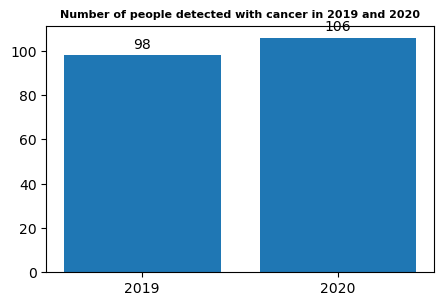

In [36]:
df_year = data_eda['Year'].astype(int).astype(str).value_counts().to_frame().sort_index()
labels = df_year.index
values = df_year.iloc[:,0]

fig,ax = plt.subplots(figsize = (5,3.2))
rects = ax.bar(labels, values)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(text = height, 
                    xy = (rect.get_x() + rect.get_width()/2, height), 
                    xytext = (0,3), 
                    textcoords = 'offset points', 
                    ha = 'center', 
                    va = 'bottom')
autolabel(rects)
ax.set_title("Number of people detected with cancer in 2019 and 2020", fontsize = 8, fontweight = "bold", color = "black")
fig.show()

### Bivariate Analysis

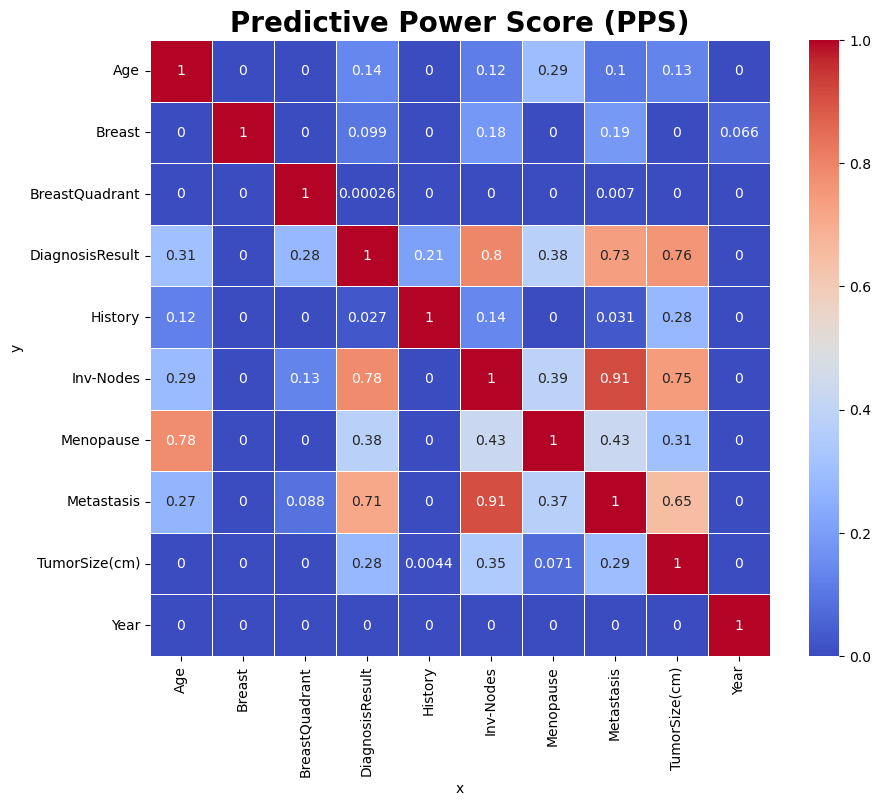

In [37]:
matrix_df = pps.matrix(data_eda)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

plt.figure(figsize = (10,8))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="coolwarm", linewidths=0.5, annot=True)
plt.title("Predictive Power Score (PPS)", fontsize = 20, fontweight = 'bold', color = 'black')
plt.show()

### Age vs TumorSize(cm)

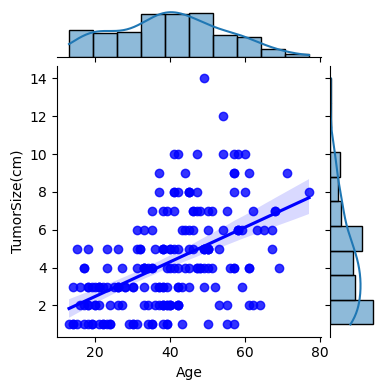

In [38]:
# Age vs TumorSize(cm)
g = sns.jointplot(data_eda, x = 'Age', y = 'TumorSize(cm)',kind = "reg", height = 4, joint_kws = {'color':'blue'})
g.fig.show()

In [39]:
# We will use the Spearman correlation because both variables do not come from a population with a Normal Distribution.
pg.corr(x = data_eda['TumorSize(cm)'], y = data_eda['Age'], method = "spearman")

,n,r,CI95%,p-val,power
spearman,204,0.522315,"[0.41, 0.62]",1.126090e-15,1.0


#### Bins Age vs DiagnosisResult

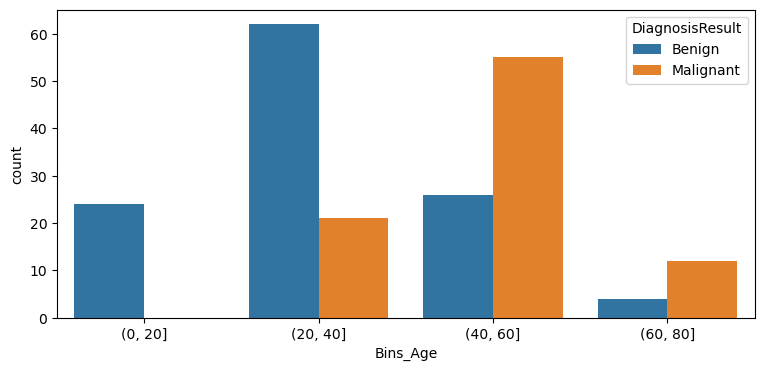

In [40]:
# Discretize the Age variable to display the number of people according to the DiagnosisResult.
data_eda['Bins_Age'] = pd.cut(data_eda['Age'],[0,20,40,60,80])
df_age_diagnosis = data_eda[['Bins_Age','DiagnosisResult']].value_counts().to_frame().stack().reset_index()
df_age_diagnosis = df_age_diagnosis.drop('level_2', axis = 1)
df_age_diagnosis = df_age_diagnosis.rename(columns = {0:'count'})

plt.figure(figsize = (9,4))
sns.barplot(df_age_diagnosis, x = 'Bins_Age', y = 'count', hue = 'DiagnosisResult')
plt.show()


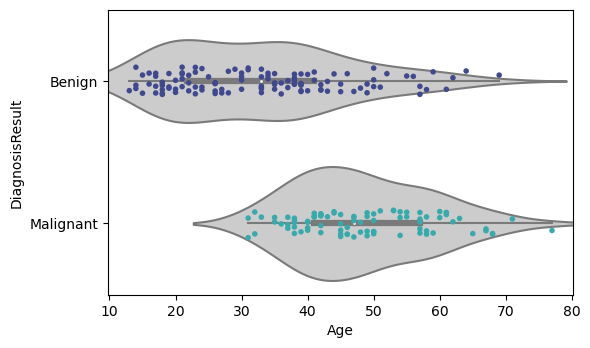

In [41]:
# Let's see how age is distributed according to the result of the diagnosis.
fig,ax = plt.subplots(figsize = (6,3.7))
sns.violinplot(data_eda, x = 'Age', y = 'DiagnosisResult', color = '.8', ax = ax)
sns.stripplot(data_eda, x = 'Age', y = 'DiagnosisResult', palette = 'mako', ax = ax, size = 4)
fig.show()

In [42]:
# Let's look at some statistics regarding this analysis.
data_eda.groupby('DiagnosisResult')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
DiagnosisResult,,,,,,,,
Benign,116.0,33.008621,13.149638,13.0,21.75,33.0,41.0,69.0
Malignant,88.0,48.443182,10.183216,31.0,41.00,47.0,57.0,77.0


#### TumorSize(cm) vs DiagnosisResult

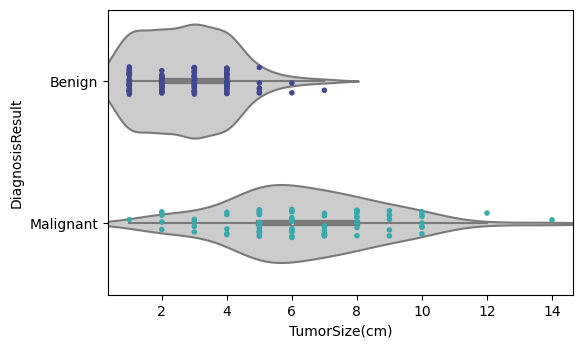

In [43]:
fig,ax = plt.subplots(figsize = (6,3.7))
sns.violinplot(data_eda, x = 'TumorSize(cm)', y = 'DiagnosisResult', color = '.8', ax = ax)
sns.stripplot(data_eda, x = 'TumorSize(cm)', y = 'DiagnosisResult', palette = 'mako', ax = ax, size = 4)
fig.show()

In [44]:
data_eda.groupby('DiagnosisResult')['TumorSize(cm)'].describe()

,count,mean,std,min,25%,50%,75%,max
DiagnosisResult,,,,,,,,
Benign,116.0,2.732759,1.347189,1.0,2.0,3.0,4.0,7.0
Malignant,88.0,6.318182,2.385519,1.0,5.0,6.0,8.0,14.0


#### TumorSize(cm) vs Metastasis

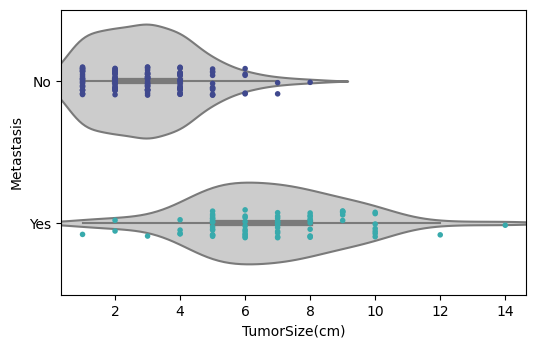

In [45]:
fig,ax = plt.subplots(figsize = (6,3.7))
sns.violinplot(data_eda, x = 'TumorSize(cm)', y = 'Metastasis', color = '.8', ax = ax)
sns.stripplot(data_eda, x = 'TumorSize(cm)', y = 'Metastasis', palette = 'mako', ax = ax, size = 4)
fig.show()

In [46]:
data_eda.groupby('Metastasis')['TumorSize(cm)'].describe()

,count,mean,std,min,25%,50%,75%,max
Metastasis,,,,,,,,
No,134.0,2.977612,1.533910,1.0,2.0,3.0,4.0,8.0
Yes,70.0,6.771429,2.322988,1.0,5.0,7.0,8.0,14.0


#### Multivariate Analysis

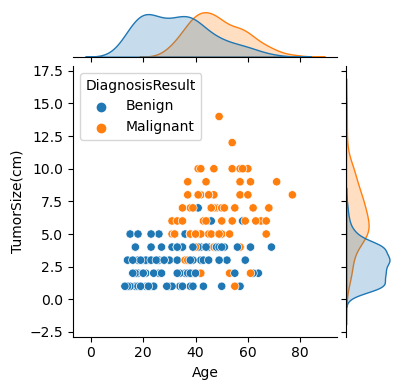

In [47]:
g = sns.jointplot(data_eda, x = 'Age', y = 'TumorSize(cm)', hue = 'DiagnosisResult',height = 4)
g.fig.show()

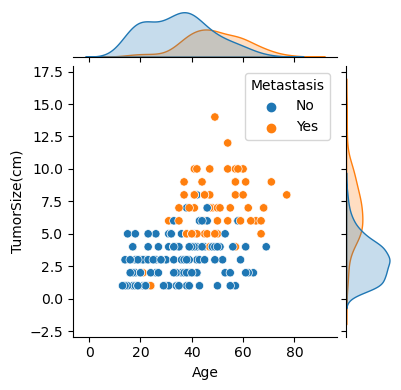

In [48]:
g = sns.jointplot(data_eda, x = 'Age', y = 'TumorSize(cm)', hue = 'Metastasis', height = 4)
g.fig.show()

#### Preprocessing

In [49]:
# Separate our data set into target variable and features.
X = data.drop('DiagnosisResult', axis = 1)
y = data['DiagnosisResult']

In [50]:
# Create a dictionary to map the target variable.
label2id = {'Benign':0., 'Malignant':1.}

y = y.map(label2id)

In [51]:
# We divide into training and testing.

# random seed for reproducibility.
SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = SEED)

In [52]:
y_train.value_counts()

0.0    84
1.0    58
Name: DiagnosisResult, dtype: int64

In [53]:
y_test.value_counts()

0.0    32
1.0    30
Name: DiagnosisResult, dtype: int64

In [54]:
# We select the variables to which we are going to apply some type of transformation.
categorical_cols = ['Year', 'Breast', 'BreastQuadrant']
numerical_cols = ['Age', 'TumorSize(cm)']

preprocessor = ColumnTransformer([('scaler', PowerTransformer(), numerical_cols),
                                  ('ohe', OneHotEncoder(drop = 'first', sparse_output = False, handle_unknown = 'ignore'), categorical_cols)], 
                                 remainder = 'passthrough', verbose_feature_names_out = False).set_output(transform = 'pandas')

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

####  Models

In [55]:
# We define the scale_pos_weight for our XGBClassifier to handle class imbalance.
scale_pos_weight = Counter(y_train)[0] / Counter(y_train)[1]
scale_pos_weight

1.4482758620689655

In [56]:
# We define the candidate models, we choose the model that best generalizes.
clf1 = LogisticRegression(class_weight = 'balanced', random_state = SEED, n_jobs = -1, max_iter = 1000)
clf2 = RandomForestClassifier(random_state = SEED, n_jobs = -1)
clf3 = ExtraTreesClassifier(bootstrap = True, class_weight = 'balanced', n_jobs = -1, random_state = SEED)
clf4 = XGBClassifier(scale_pos_weight = scale_pos_weight, random_state = SEED, n_jobs = -1)
clf5 = LGBMClassifier(class_weight = 'balanced', random_state = SEED, n_jobs = -1)
clf6 = CatBoostClassifier(auto_class_weights = 'SqrtBalanced', random_state = SEED, verbose = 0)
clf7 = SVC(probability = True, class_weight = 'balanced', random_state = SEED)

MODELS = [clf1, clf2, clf3, clf4, clf5, clf6, clf7]

In [57]:
# Training!!!
#=====================================================================
accuracy_train = {}
accuracy_test = {}

for model in tqdm(MODELS):
    name = type(model).__name__
    model.fit(X_train_prep, y_train)
    y_pred_train = model.predict(X_train_prep)
    y_pred_test = model.predict(X_test_prep)
    accuracy_train[name] = balanced_accuracy_score(y_train, y_pred_train)
    accuracy_test[name] = balanced_accuracy_score(y_test, y_pred_test)
    print(f'* {name} finished.')

  0%|          | 0/7 [00:00<?, ?it/s]

* LogisticRegression finished.
* RandomForestClassifier finished.
* ExtraTreesClassifier finished.
* XGBClassifier finished.
[LightGBM] [Info] Number of positive: 58, number of negative: 84
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 142, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

* CatBoostClassifier finished.
* SVC finished.


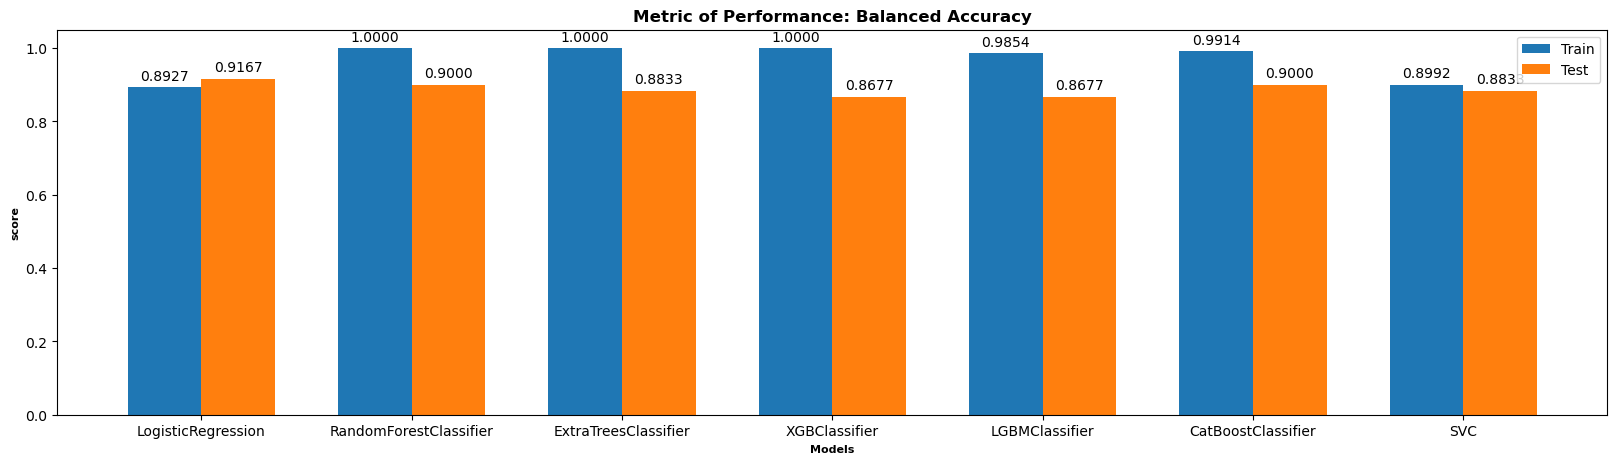

In [58]:
metric_train = pd.DataFrame.from_dict(accuracy_train, orient = 'index')
metric_train = metric_train.rename(columns = {0:'Train'})

metric_test = pd.DataFrame.from_dict(accuracy_test, orient = 'index')
metric_test = metric_test.rename(columns = {0:'Test'})

fig,ax = plt.subplots(figsize = (20,5))

labels = metric_train.index.to_list()
values_train = metric_train.iloc[:,0].to_list()
values_test = metric_test.iloc[:,0].to_list()
x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x = x - width/2, height = values_train, width = width, label = 'Train')
rects2 = ax.bar(x = x + width/2, height = values_test, width = width, label = 'Test')


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(text = f'{height:.4f}', 
                    xy = (rect.get_x() + rect.get_width()/2, height), 
                    xytext = (0,3), 
                    textcoords = "offset points", 
                    ha = "center", 
                    va = "bottom")
        
autolabel(rects1)
autolabel(rects2)
ax.legend()
ax.set_title("Metric of Performance: Balanced Accuracy", fontsize = 12, fontweight = "bold", color = "black")
ax.set_ylabel("score", fontsize = 8, fontweight = "bold", color = "black")
ax.set_xlabel("Models", fontsize = 8, fontweight = "bold", color = "black")
ax.set_xticks(x)
ax.set_xticklabels(labels)
fig.show()


**The model that generalized best was LogisticRegression.

#### Plot Metrics

In [59]:
# Predicitions with LogisticRegression

y_pred_train = clf1.predict(X_train_prep)
y_pred_prob_train = clf1.predict_proba(X_train_prep)[:,1]

y_pred_test = clf1.predict(X_test_prep)
y_pred_prob_test = clf1.predict_proba(X_test_prep)[:,1]

***Clasification Report

In [60]:
print('--------------------------------------------------------------')
print(' ' * 14, 'Classification Report Train')
print('--------------------------------------------------------------')
print(classification_report(y_train, y_pred_train, target_names = ['Benign','Malignant']))
print('')
print('--------------------------------------------------------------')
print(' ' * 14, 'Classification Report Test')
print('--------------------------------------------------------------')
print(classification_report(y_test, y_pred_test, target_names = ['Benign','Malignant']))

--------------------------------------------------------------
               Classification Report Train
--------------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.90      0.94      0.92        84
   Malignant       0.91      0.84      0.88        58

    accuracy                           0.90       142
   macro avg       0.90      0.89      0.90       142
weighted avg       0.90      0.90      0.90       142


--------------------------------------------------------------
               Classification Report Test
--------------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.86      1.00      0.93        32
   Malignant       1.00      0.83      0.91        30

    accuracy                           0.92        62
   macro avg       0.93      0.92      0.92        62
weighted avg       0.93      0.92      0.92        62



#### Confusion Matrix

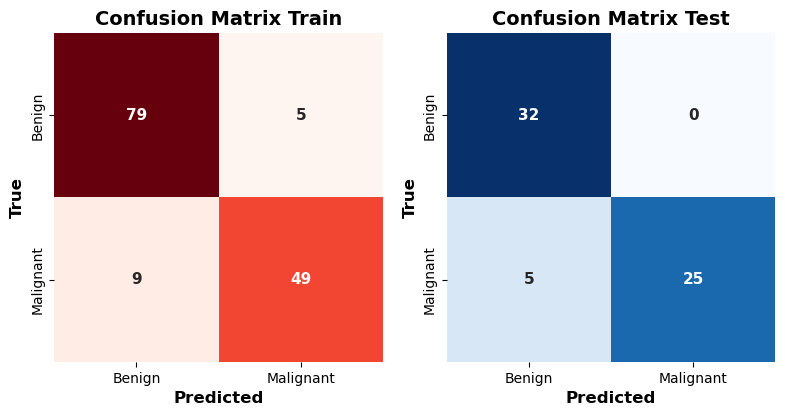

In [61]:
cf_mx_train = confusion_matrix(y_train, y_pred_train)
cf_mx_test = confusion_matrix(y_test, y_pred_test)

fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
axs = axs.flat

sns.heatmap(cf_mx_train, cmap = 'Reds', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, fmt = '', cbar = False, square = True, xticklabels = ['Benign','Malignant'], yticklabels = ['Benign','Malignant'], ax = axs[0])
sns.heatmap(cf_mx_test, cmap = 'Blues', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, fmt = '', cbar = False, square = True, xticklabels = ['Benign','Malignant'], yticklabels = ['Benign','Malignant'], ax = axs[1])
axs[0].set_xlabel('Predicted', fontsize = 12, fontweight = "bold", color = "black")
axs[1].set_xlabel('Predicted', fontsize = 12, fontweight = "bold", color = "black")
axs[0].set_ylabel('True', fontsize = 12, fontweight = "bold", color = "black")
axs[1].set_ylabel('True', fontsize = 12, fontweight = "bold", color = "black")
axs[0].set_title('Confusion Matrix Train', fontsize = 14, fontweight = "bold", color = "black")
axs[1].set_title('Confusion Matrix Test', fontsize = 14, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()

#### Precision Recall Curve

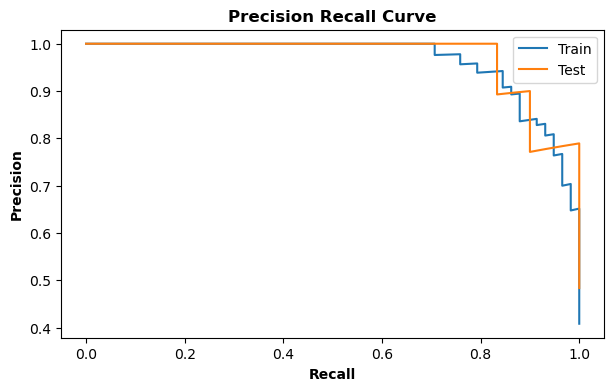

In [62]:
precision_train, recall_train, _ = precision_recall_curve(y_train, 
                                                          y_pred_prob_train)

precision_test, recall_test, _ = precision_recall_curve(y_test, 
                                                        y_pred_prob_test)

fig,ax = plt.subplots(figsize = (7,4))

ax.plot(recall_train, precision_train, label = 'Train')
ax.plot(recall_test, precision_test, label = 'Test')
ax.set_title("Precision Recall Curve", fontsize = 12, fontweight = "bold")
ax.set_xlabel("Recall", fontsize = 10, fontweight = "bold", color = "black")
ax.set_ylabel("Precision", fontsize = 10, fontweight = "bold", color = "black")
ax.legend()
fig.show()


#### ROC Curve

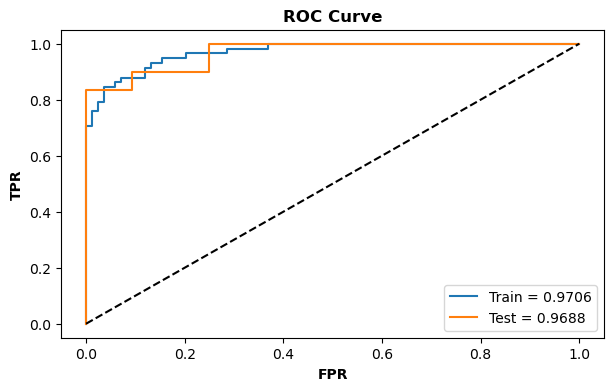

In [63]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_prob_train)
auc_train = roc_auc_score(y_train, y_pred_prob_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)
auc_test = roc_auc_score(y_test, y_pred_prob_test)

fig,ax = plt.subplots(figsize = (7,4))

ax.plot(fpr_train, tpr_train, label = f'Train = {auc_train:.4f}')
ax.plot(fpr_test, tpr_test, label = f'Test = {auc_test:.4f}')
ax.plot([0,1], linestyle = '--', color = 'black')
ax.set_title("ROC Curve", fontsize = 12, fontweight = "bold")
ax.set_xlabel("FPR", fontsize = 10, fontweight = "bold", color = "black")
ax.set_ylabel("TPR", fontsize = 10, fontweight = "bold", color = "black")
ax.legend()
fig.show()

### Feature Importance

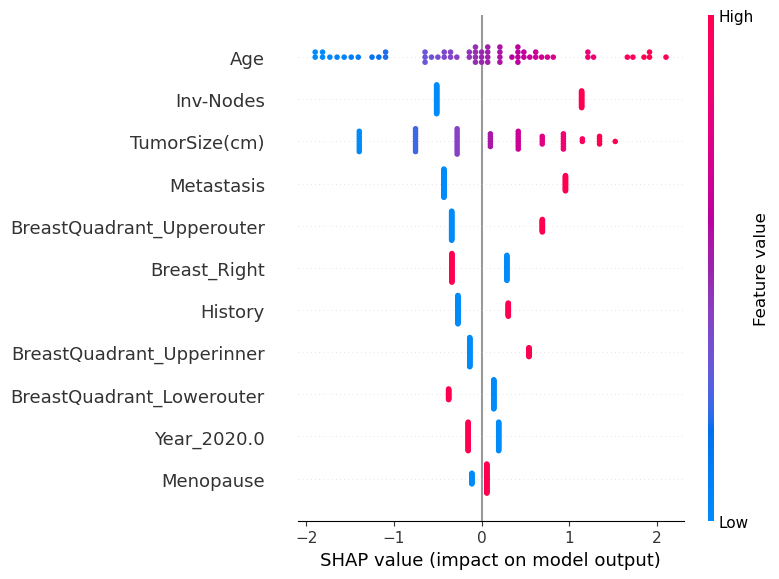

In [64]:
explainer = shap.LinearExplainer(clf1, X_train_prep, seed = SEED)
shap_values = explainer.shap_values(X_test_prep)

shap.summary_plot(shap_values, X_test_prep)
shap.initjs()